In [68]:
import pickle
from os.path import join
import os
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d

In [69]:
data_dir = 'results'

In [70]:
# get all pickled results
paths = [join(data_dir, path) for path in os.listdir(data_dir) if 'all' not in path]

In [71]:
with open(paths[0], 'rb') as f:
    x = pickle.load(f)
x

{'num_bits': 512,
 'neural': {'num_pairs': 50,
  'acc_train': 0.9975298663905235,
  'acc_test': 0.9819235723486475,
  'mae': 0.1318562328168192,
  'model_name': 'get_base_model',
  'plot_paths': ('save_dir/history_acc_50-512',
   'save_dir/history_loss_50-512')},
 'minhash': {'mae': 0.15748612479347002}}

In [72]:
# we need a dict with pairs then bit errors in net and sim
result = defaultdict(lambda: dict())

In [73]:
for filename in paths:
    pairs, bits = re.findall('\d+', filename)
    
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    result[pairs][bits] = {
        'neural_mae': data['neural']['mae'],
        'neural_acc': data['neural']['acc_test'],
        'minhash_mae': data['minhash']['mae']
    }


In [74]:
result = dict(result)
result['25']

{'16': {'neural_mae': 0.2418747130603947,
  'neural_acc': 0.9818806354658651,
  'minhash_mae': 0.19637612530031867},
 '256': {'neural_mae': 0.14366641108769374,
  'neural_acc': 0.991841992271361,
  'minhash_mae': 0.17732180838722003},
 '64': {'neural_mae': 0.17951633428375116,
  'neural_acc': 0.9815657649921282,
  'minhash_mae': 0.17133320815766515},
 '32': {'neural_mae': 0.35666591311051243,
  'neural_acc': 0.9667382281379705,
  'minhash_mae': 0.0914501636014018},
 '128': {'neural_mae': 0.19441208515422503,
  'neural_acc': 0.982825246887076,
  'minhash_mae': 0.19442149598543135},
 '512': {'neural_mae': 0.20990369402233677,
  'neural_acc': 0.9804494060397881,
  'minhash_mae': 0.15748612479347004}}

In [75]:
def plot_results(data, num_pairs, smooth=True):

    x = sorted(data.keys(), key=int)
    
    plt.figure(int(num_pairs)+1)
    mae_minhash = [data[num_bit]['minhash_mae'] for num_bit in x]
    mae_neural = [data[num_bit]['neural_mae'] for num_bit in x]
    
    if smooth:
        # smooth neural net curve
        start, stop = mae_neural[0],  mae_neural[-1]
        mae_neural = gaussian_filter1d(mae_neural, sigma=1).tolist()
        mae_neural[0] = start
        mae_neural[-1] = stop

    plt.plot(x, mae_minhash, label='WeightedMinhash hashes')
    plt.plot(x, mae_neural, label='Model hashes')
    
    plt.title(f'MAE for {num_pairs} pairs.')
    plt.xlabel('Number of bits')
    plt.ylabel('MAE in similarity')
    plt.legend(loc='upper right')
    plt.savefig('minhash_neural_curve.png')
    
    plt.show()
    

In [76]:
# sorted_pairs = sorted(result.keys(), key=int)
# for num_pairs in sorted_pairs:
#     plot_results(result[num_pairs], num_pairs)

In [77]:
min_val = {
    'mae_neural': {'val': 1, 'num_bit': None, 'num_pairs': None},
    'mae_minhash': {'val': 1, 'num_bit': None, 'num_pairs': None}
}

In [78]:
for num_pairs in result.keys():
    for num_bit in result[num_pairs].keys():
        if result[num_pairs][num_bit]['neural_mae'] < min_val['mae_neural']['val']:
            min_val['mae_neural']['val'] = result[num_pairs][num_bit]['neural_mae']
            min_val['mae_neural']['num_bit'] = num_bit
            min_val['mae_neural']['num_pairs'] = num_pairs
        
        if result[num_pairs][num_bit]['minhash_mae'] < min_val['mae_minhash']['val']:
            min_val['mae_minhash']['val'] = result[num_pairs][num_bit]['minhash_mae']
            min_val['mae_minhash']['num_bit'] = num_bit
            min_val['mae_minhash']['num_pairs'] = num_pairs

In [79]:
min_val

{'mae_neural': {'val': 0.1318562328168192,
  'num_bit': '512',
  'num_pairs': '50'},
 'mae_minhash': {'val': 0.0914501636014018,
  'num_bit': '32',
  'num_pairs': '50'}}

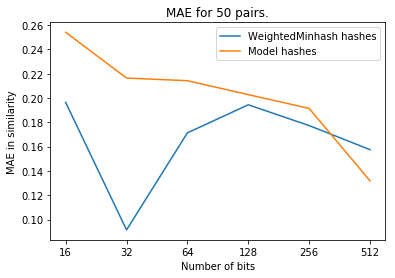

In [80]:
plot_results(result['50'], 50)

In [14]:
result['50']['32']

{'neural_mae': 0.15785976638156296,
 'neural_acc': 0.9785888077858881,
 'minhash_mae': 0.0914501636014018}

In [15]:
result['50']['512']

{'neural_mae': 0.1318562328168192,
 'neural_acc': 0.9819235723486475,
 'minhash_mae': 0.15748612479347002}